## Southern Pre Eruption Average

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import cartopy.util as util
import matplotlib as mpl
from glob import glob
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline
import scipy.stats as stats
import netCDF4 as nc4
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

mpl.rcParams['figure.figsize'] = [10,4]
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['savefig.dpi'] = 200

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'
mpl.rcParams['lines.linewidth']= 2.0
mpl.rcParams['xtick.labelsize']=16
mpl.rcParams['ytick.labelsize']=16

### Loading in files and variables

In [2]:
casePath='/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.BWmaHIST.f19_g17.PMIP4-past1000.002/ocn/proc/tseries/month_1/'
caseName='b.e21.BWmaHIST.f19_g17.PMIP4-past1000.002'

In [3]:
case = casePath + caseName + '.pop.h.' + 'TEMP.*' + '.nc' #sample one 0020-12.nc' 
data = xr.open_mfdataset(case)
data

<xarray.Dataset>
Dimensions:                 (time: 12000, moc_comp: 3, transport_comp: 5,
                             transport_reg: 2, z_t: 60, z_t_150m: 15, z_w: 60,
                             z_w_top: 60, z_w_bot: 60, lat_aux_grid: 395,
                             moc_z: 61, nlat: 384, nlon: 320, d2: 2)
Coordinates:
  * z_t                     (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m                (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
  * z_w                     (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_top                 (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot                 (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * lat_aux_grid            (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
  * moc_z                   (moc_z) float32 0.0 1e+03 2e+03 ... 5.25e+05 5.5e+05
    ULONG                   (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                   (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time                    (time) object 0850-02-01 00:00:00 ... 1850-01-01 ...
Dimensions without coordinates: moc_comp, transport_comp, transport_reg, nlat,
                                nlon, d2
Data variables: (12/55)
    moc_components          (time, moc_comp) |S384 dask.array<chunksize=(600, 3), meta=np.ndarray>
    transport_components    (time, transport_comp) |S384 dask.array<chunksize=(600, 5), meta=np.ndarray>
    transport_regions       (time, transport_reg) |S384 dask.array<chunksize=(600, 2), meta=np.ndarray>
    dz                      (time, z_t) float32 dask.array<chunksize=(600, 60), meta=np.ndarray>
    dzw                     (time, z_w) float32 dask.array<chunksize=(600, 60), meta=np.ndarray>
    KMT                     (time, nlat, nlon) float64 dask.array<chunksize=(600, 384, 320), meta=np.ndarray>
    ...                      ...
    salinity_factor         (time) float64 -0.00347 -0.00347 ... -0.00347
    sflux_factor            (time) float64 0.1 0.1 0.1 0.1 ... 0.1 0.1 0.1 0.1
    nsurface_t              (time) float64 8.61e+04 8.61e+04 ... 8.61e+04
    nsurface_u              (time) float64 8.297e+04 8.297e+04 ... 8.297e+04
    time_bound              (time, d2) object dask.array<chunksize=(600, 2), meta=np.ndarray>
    TEMP                    (time, z_t, nlat, nlon) float32 dask.array<chunksize=(600, 60, 384, 320), meta=np.ndarray>
Attributes:
    title:             b.e21.BWmaHIST.f19_g17.PMIP4-past1000.002
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2020-08-29 at 18:17:31.8
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [4]:
def pop_add_cyclic(data,TLAT,TLONG): 
    nj = TLAT.shape[0] # size of POP grid
    ni = TLONG.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)
    tlon = TLONG
    tlat = TLAT
    tlon = np.where(np.greater_equal(tlon, min(tlon[:,0])), tlon-360., tlon) #make monotoncially increasing
    lon  = np.concatenate((tlon, tlon + 360.), 1) # concatenate to make larger array
    lon = lon[:, xL:xR] #restrict to middle rane
    if ni == 320: # this is the x1 POP grid
        lon[367:-3, 0] = lon[367:-3, 0] + 360.        
    lon = lon - 360.
    lon = np.hstack((lon, lon[:, 0:1] + 360.)) # add in cyclic point
    if ni == 320:
        lon[367:, -1] = lon[367:, -1] - 360.
    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:, 0] = lon[:, 0] - 1e-8
    #-- periodicity
    lat = np.concatenate((tlat, tlat), 1)
    lat = lat[:, xL:xR]
    lat = np.hstack((lat, lat[:,0:1]))
    lon_dim = 1 #ds[v].dims.index('nlon')
    field = data
    field = np.concatenate((field, field), 1)
    field = field[:, xL:xR]
    field = np.concatenate((field, field[:, 0:1]), lon_dim)
    
    return field, lat, lon

In [5]:
from scipy.ndimage import uniform_filter1d

def rolling_mean(a, W, axis=-1):
    # a : Input ndarray
    # W : Window size
    # axis : Axis along which we will apply rolling/sliding mean
    hW = W//2
    L = a.shape[axis]-W+1   
    indexer = [slice(None) for _ in range(a.ndim)]
    indexer[axis] = slice(hW,hW+L)
    return uniform_filter1d(a,W,axis=axis)[tuple(indexer)]

In [6]:
def ENSO_area_weighted_mean(var,TAREA):  
    # assumes 2D field as var input
    # make sure masking is correct, otherwise we get nans
    var = np.ma.masked_invalid(var)
    TAREA = np.ma.masked_invalid(TAREA) # I think this is necessary
    # resulting variable should have dimensions of depth and time (x)
    ave = np.zeros(var.shape[0])
    # loop over time
    for t in np.arange(var.shape[0]):
        ave[t] = np.ma.average(var[t,167:206,203:248],weights=TAREA[167:206,203:248])
    return ave

In [7]:
def Trop_area_weighted_mean(var,TAREA):  
    # assumes 2D field as var input
    # make sure masking is correct, otherwise we get nans
    var = np.ma.masked_invalid(var)
    TAREA = np.ma.masked_invalid(TAREA) # I think this is necessary
    # resulting variable should have dimensions of depth and time (x)
    ave = np.zeros(var.shape[0])
    # loop over time
    for t in np.arange(var.shape[0]):
        ave[t] = np.ma.average(var[t],weights=TAREA)
    return ave

### Get the lat and lon locations for the El Nino region: 

In [8]:
data['TLAT'][206,50].values

array(5.18019218)

In [9]:
data['TLAT'][167,50].values

array(-5.2090898)

In [10]:
abs(data['TLONG'][50,203].values-360)

171.06249474233516

In [11]:
abs(data['TLONG'][50,248].values-360)

120.43749333356618

### Pulling SST and monthly

In [12]:
data = data.TEMP[:,0,:,:]
data

<xarray.DataArray 'TEMP' (time: 12000, nlat: 384, nlon: 320)>
dask.array<getitem, shape=(12000, 384, 320), dtype=float32, chunksize=(600, 384, 320), chunktype=numpy.ndarray>
Coordinates:
    z_t      float32 500.0
    ULONG    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time     (time) object 0850-02-01 00:00:00 ... 1850-01-01 00:00:00
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Potential Temperature
    units:         degC
    grid_loc:      3111
    cell_methods:  time: mean

In [13]:
monthlydata=data.sel(time=slice('1000-01-01 00:00:00','1030-12-31 00:00:00')).groupby('time.month').mean(dim='time')

### Southern Hemisphere Volcanoes

In [14]:
volc=xr.open_mfdataset('/glade/p/cesmdata/cseg/inputdata/atm/cam/chem/stratvolc/Volcanic_SO2_eVolv2k_CESM_UKESM_v3_800-1890_noLaki_2deg_c20200303.nc',decode_times=False)
volc

<xarray.Dataset>
Dimensions:       (altitude_int: 4, time: 506, altitude: 3, lat: 96, lon: 144)
Coordinates:
  * altitude_int  (altitude_int) float32 0.0 18.0 20.0 40.0
  * altitude      (altitude) float32 9.0 19.0 30.0
  * lat           (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon           (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Dimensions without coordinates: time
Data variables:
    date          (time) float64 dask.array<chunksize=(506,), meta=np.ndarray>
    datesec       (time) float64 dask.array<chunksize=(506,), meta=np.ndarray>
    stratvolc     (time, altitude, lat, lon) float32 dask.array<chunksize=(506, 3, 96, 144), meta=np.ndarray>
Attributes: (12/13)
    filename:           \nVolcanic_SO2_eVolv2k_CESM_UKESM_v3_800-1890_noLaki_...
    notes:              \nRemoved 1783 Laki eruption\nInstead use files:\n   ...
    title:              \nSO2 emissions from stratospheric volcanoes, 800.1.1...
    data_creator:       \nMatthew Toohey, GEOMAR Helmholtz Centre for Ocean R...
    data_doi:           \n10.26050/WDCC/eVolv2k_v3
    data_source_url:    \nhttps://doi.org/10.26050/WDCC/eVolv2k_v3
    ...                 ...
    data_source_files:  \n/glade/work/mmills/data/eVolv2k/volcanic_SO2_eVolv2...
    creation_date:      \nTue Mar  3 14:59:15 MST 2020
    cesm_contact:       \nMike Mills, NCAR ACOM, mmills@ucar.edu
    data_script:        \nConverted from data_source_files by program createV...
    input_method:       SERIAL
    data_summary:       \nEach day of eruption, the emission occurs over 6 ho...

Chronological Order

In [15]:
unident1 = data.sel(time=slice('0852-10-01 00:00:00','0853-10-01 00:00:00')).groupby('time.month').mean(dim='time')
unident2 = data.sel(time=slice('0868-01-01 00:00:00','0869-01-01 00:00:00')).groupby('time.month').mean(dim='time')
unident3 = data.sel(time=slice('0959-07-01 00:00:00','0960-07-01 00:00:00')).groupby('time.month').mean(dim='time')
unident4 = data.sel(time=slice('1038-04-01 00:00:00','1039-04-01 00:00:00')).groupby('time.month').mean(dim='time')
unident5 = data.sel(time=slice('1268-01-01 00:00:00','1269-01-01 00:00:00')).groupby('time.month').mean(dim='time')
unident6 = data.sel(time=slice('1377-07-01 00:00:00','1378-07-01 00:00:00')).groupby('time.month').mean(dim='time')
unident7 = data.sel(time=slice('1477-10-01 00:00:00','1478-10-01 00:00:00')).groupby('time.month').mean(dim='time')
unident8 = data.sel(time=slice('1540-04-01 00:00:00','1541-04-01 00:00:00')).groupby('time.month').mean(dim='time')
unident9 = data.sel(time=slice('1620-01-01 00:00:00','1621-01-01 00:00:00')).groupby('time.month').mean(dim='time')
unident10 = data.sel(time=slice('1661-07-01 00:00:00','1662-07-01 00:00:00')).groupby('time.month').mean(dim='time')

In [16]:
unident1_pre_anomaly = unident1-monthlydata
unident2_pre_anomaly = unident2-monthlydata
unident3_pre_anomaly = unident3-monthlydata
unident4_pre_anomaly = unident4-monthlydata
unident5_pre_anomaly = unident5-monthlydata
unident6_pre_anomaly = unident6-monthlydata
unident7_pre_anomaly = unident7-monthlydata
unident8_pre_anomaly = unident8-monthlydata
unident9_pre_anomaly = unident9-monthlydata
unident10_pre_anomaly = unident10-monthlydata

In [17]:
plot_data_unident1_pre, new_lats, new_lons = pop_add_cyclic(unident1_pre_anomaly.mean(dim = 'month'),data['TLAT'],data['TLONG'])
plot_data_unident2_pre, new_lats, new_lons = pop_add_cyclic(unident2_pre_anomaly.mean(dim = 'month'),data['TLAT'],data['TLONG'])
plot_data_unident3_pre, new_lats, new_lons = pop_add_cyclic(unident3_pre_anomaly.mean(dim = 'month'),data['TLAT'],data['TLONG'])
plot_data_unident4_pre, new_lats, new_lons = pop_add_cyclic(unident4_pre_anomaly.mean(dim = 'month'),data['TLAT'],data['TLONG'])
plot_data_unident5_pre, new_lats, new_lons = pop_add_cyclic(unident5_pre_anomaly.mean(dim = 'month'),data['TLAT'],data['TLONG'])
plot_data_unident6_pre, new_lats, new_lons = pop_add_cyclic(unident6_pre_anomaly.mean(dim = 'month'),data['TLAT'],data['TLONG'])
plot_data_unident7_pre, new_lats, new_lons = pop_add_cyclic(unident7_pre_anomaly.mean(dim = 'month'),data['TLAT'],data['TLONG'])
plot_data_unident8_pre, new_lats, new_lons = pop_add_cyclic(unident8_pre_anomaly.mean(dim = 'month'),data['TLAT'],data['TLONG'])
plot_data_unident9_pre, new_lats, new_lons = pop_add_cyclic(unident9_pre_anomaly.mean(dim = 'month'),data['TLAT'],data['TLONG'])
plot_data_unident10_pre, new_lats, new_lons = pop_add_cyclic(unident10_pre_anomaly.mean(dim = 'month'),data['TLAT'],data['TLONG'])

In [18]:
plot_data_pre_average = (plot_data_unident1_pre +
                         plot_data_unident2_pre +
                         plot_data_unident3_pre +
                         plot_data_unident4_pre +
                         plot_data_unident5_pre +
                         plot_data_unident6_pre +
                         plot_data_unident7_pre +
                         plot_data_unident8_pre +
                         plot_data_unident9_pre+
                         plot_data_unident10_pre) / 10

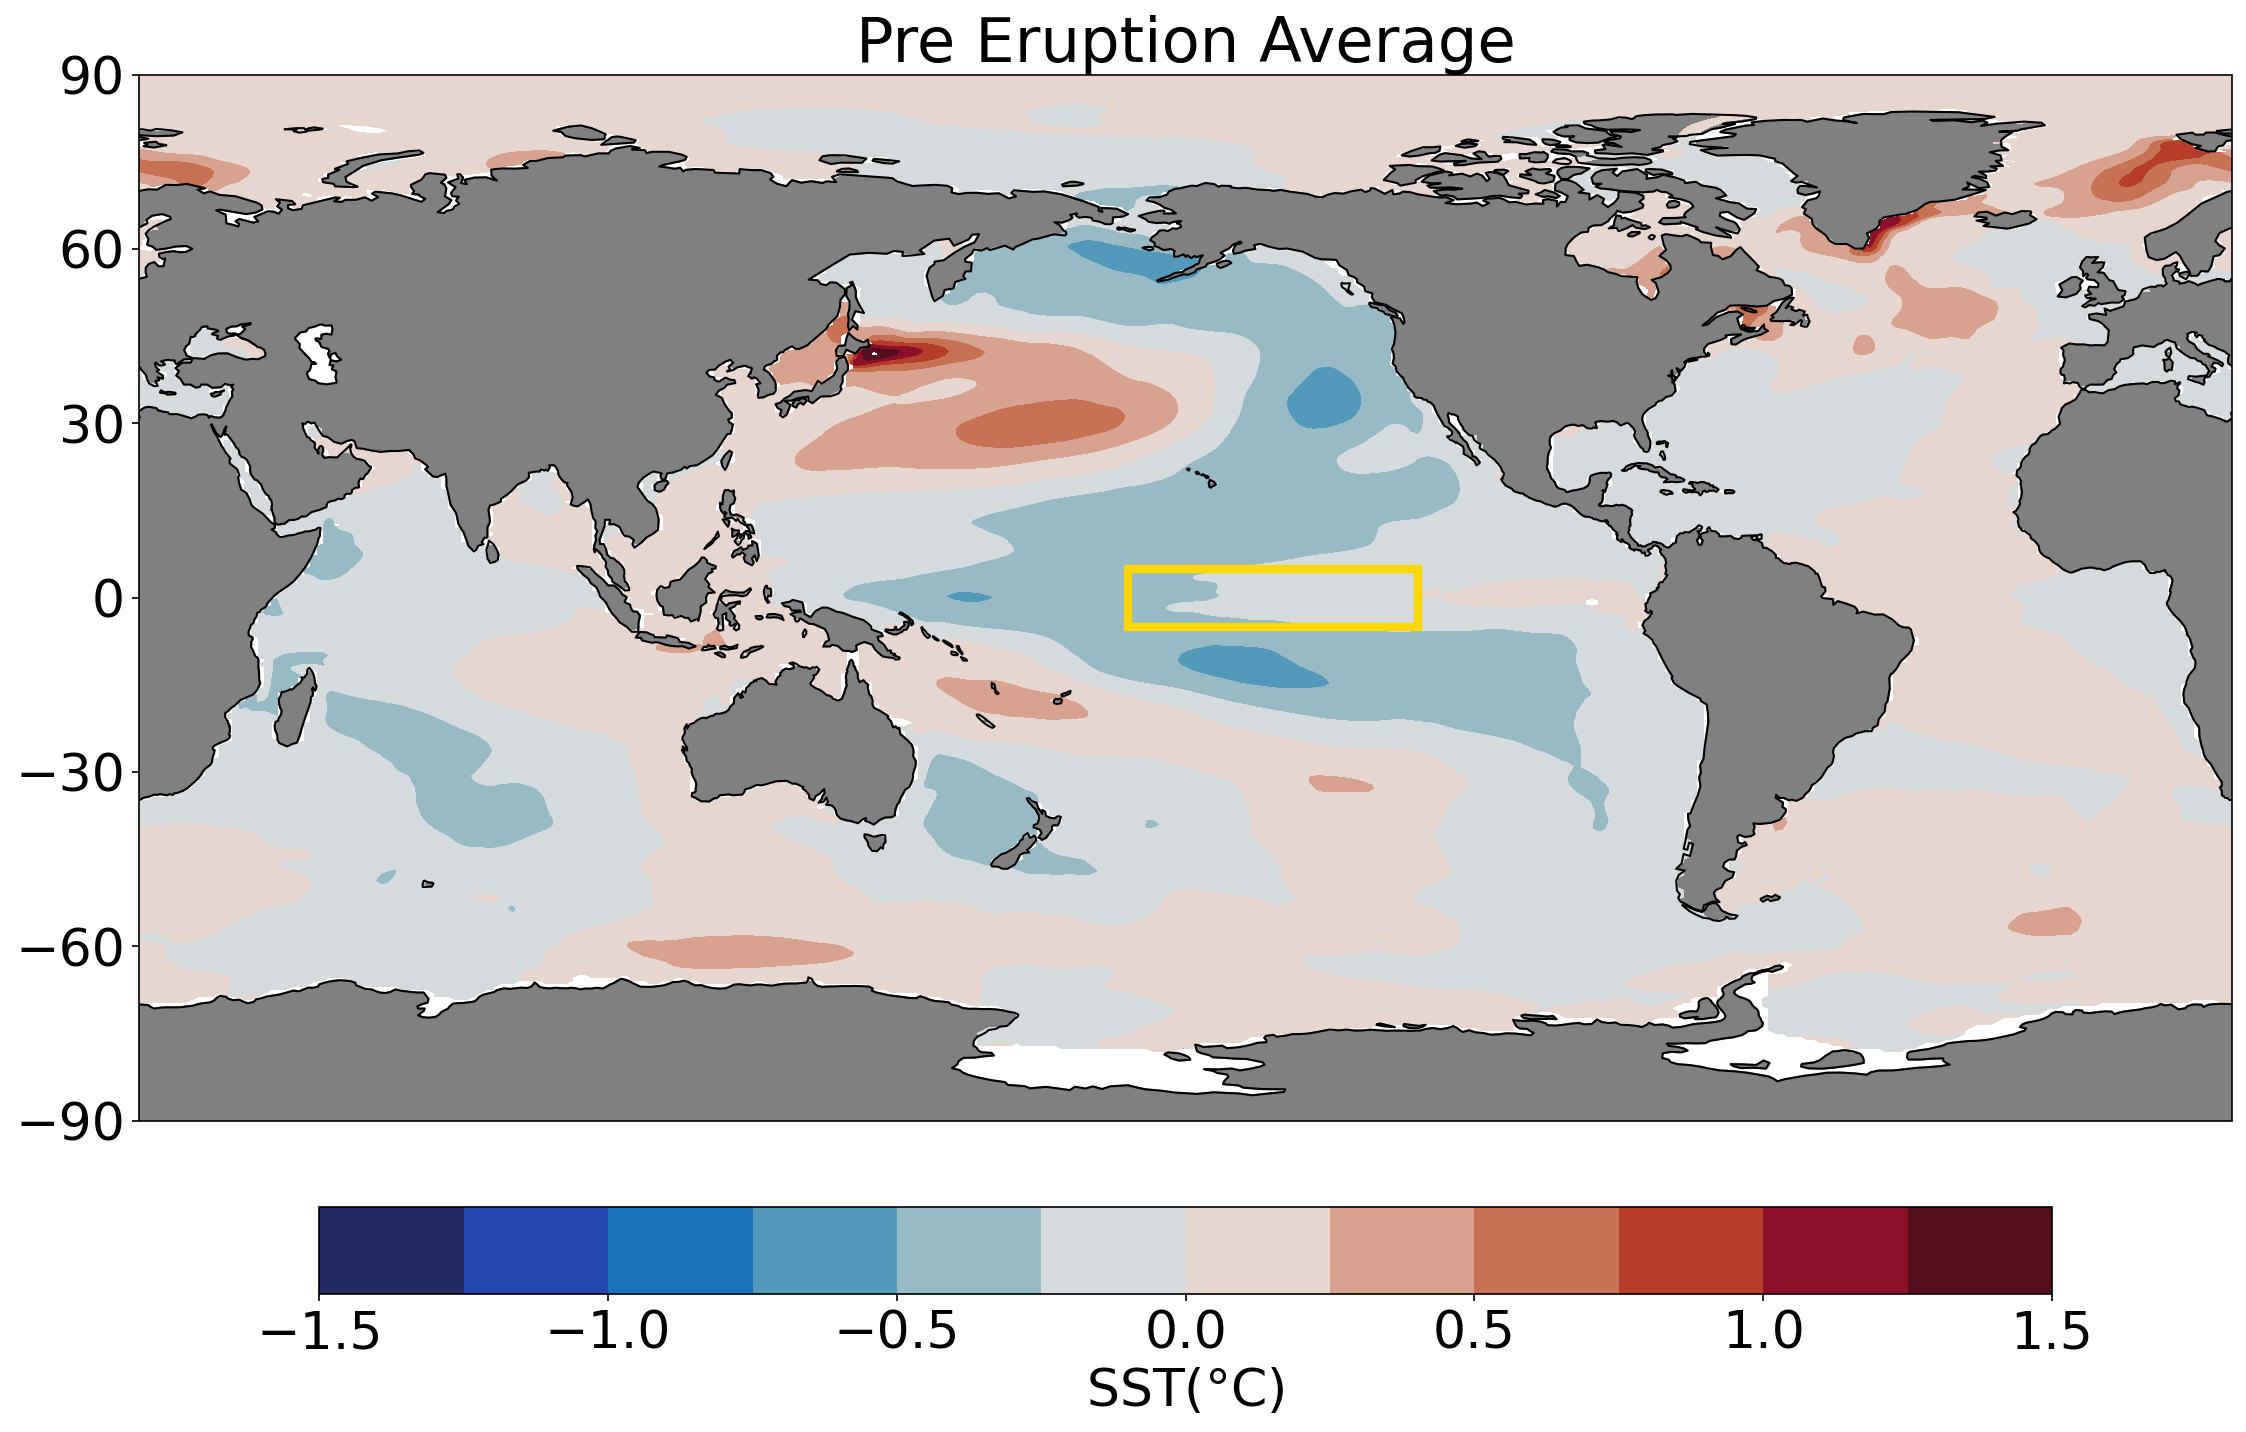

In [19]:
projection=ccrs.PlateCarree(central_longitude = -160)
#projection=ccrs.Robinson(central_longitude=-160, globe=None)
fig,ax= plt.subplots(figsize =(18,15),subplot_kw=dict(projection=projection))

ax.add_feature(cfeature.LAND, color = 'gray')
ax.add_feature(cfeature.COASTLINE)
ax.set_global()

min_level=-1.5
max_level=1.5
step_level=0.25

levels = np.arange(min_level, max_level + step_level, step_level)
p = plt.contourf(new_lons,new_lats, plot_data_pre_average,levels=levels,
                transform=ccrs.PlateCarree(),cmap = cmocean.cm.balance,zorder=-1)
plt.yticks([-90, -60, -30, 0, 30, 60, 90], size=25)
#plt.axhline(y=5)
#plt.axhline(y=-5)
#plt.axvline(x=-10)
#plt.axvline(x=40)
        
ax.add_patch(mpatches.Rectangle((-10, 5), 50, -10, edgecolor='gold',
   facecolor='none', linewidth=4))

plt.title('Pre Eruption Average', size=30)
cbar = plt.colorbar(p, orientation='horizontal', pad=0.05, fraction=0.05,ax=ax)
cbar.ax.tick_params(labelsize=25)
cbar.set_label('SST' + "($\degree$C)", size = 25)

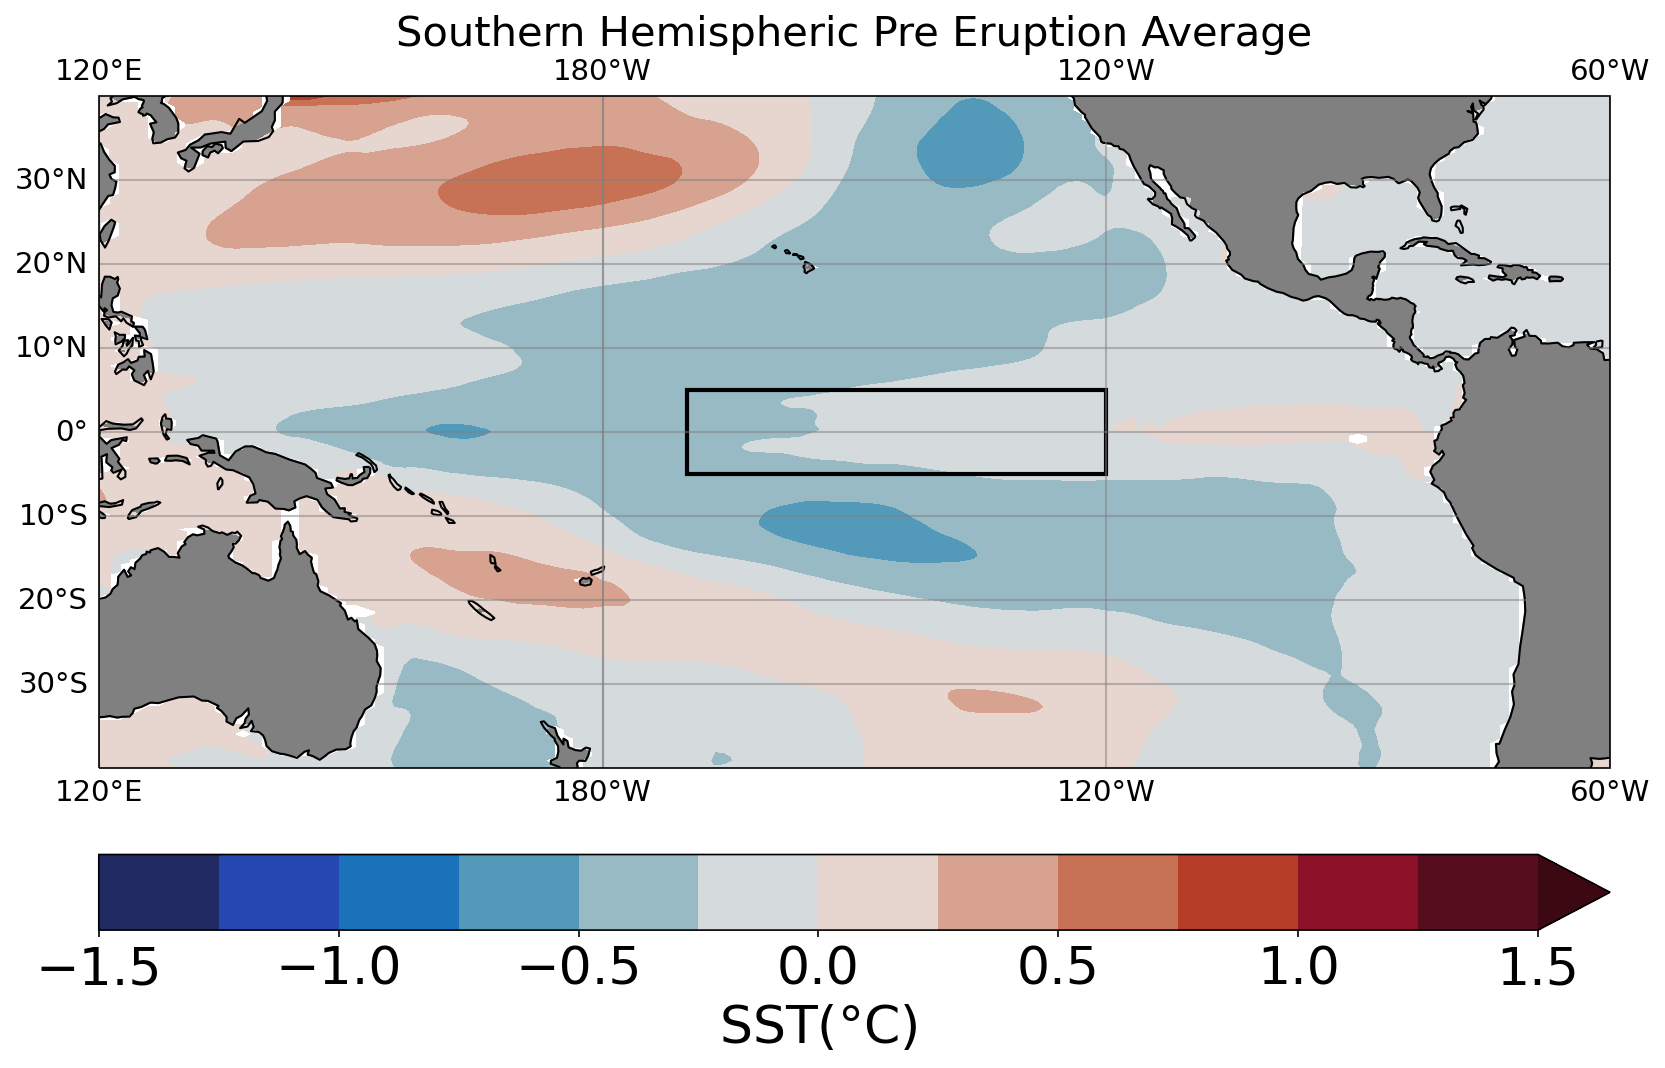

In [20]:
fig,ax= plt.subplots(figsize =(13,15),subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=-160)))
ax.add_feature(cfeature.LAND, color = 'grey',zorder=1)
ax.add_feature(cfeature.COASTLINE)
ax.set_global()

ax.set_extent([-240,-60,40,-40],crs=ccrs.PlateCarree() ) 

min_level=-1.5
max_level=1.5
step_level=0.25

p = plt.contourf(new_lons,new_lats, plot_data_pre_average,extend='max',levels=levels,
                transform=ccrs.PlateCarree(),cmap = cmocean.cm.balance)

gl1 = ax.gridlines(ccrs.PlateCarree(),
             linestyle='-',
             y_inline=False, x_inline=False,
             color='grey', alpha=.5, linewidth=1, draw_labels=True)
gl1.xformatter = LONGITUDE_FORMATTER
gl1.yformatter = LATITUDE_FORMATTER


ax.add_patch(mpatches.Rectangle((-10, 5), 50, -10, edgecolor='black',
   facecolor='none', linewidth=2))

plt.title('Southern Hemispheric Pre Eruption Average', size=20)
cbar = plt.colorbar(p, orientation='horizontal', pad=0.05, fraction=0.05,ax=ax)
cbar.ax.tick_params(labelsize=25)
cbar.set_label('SST' + "($\degree$C)", size = 25)

plt.show() 

### Saving and Loading data

#### Saving Data

In [21]:
np.savetxt('plot_data_southpre_average_og.csv', plot_data_pre_average, delimiter = ',')

In [22]:
np.savetxt('new_lats_southpre_og.csv',new_lats, delimiter = ',')

In [23]:
np.savetxt('new_lons_southpre_og.csv',new_lons, delimiter = ',')

#### Loading in

In [24]:
plot_data_pre_average = np.loadtxt('plot_data_southpre_average_og.csv', delimiter = ',')

In [25]:
new_lats = np.loadtxt('new_lats_southpre_og.csv', delimiter = ',')

In [26]:
new_lons = np.loadtxt('new_lons_southpre_og.csv', delimiter = ',')

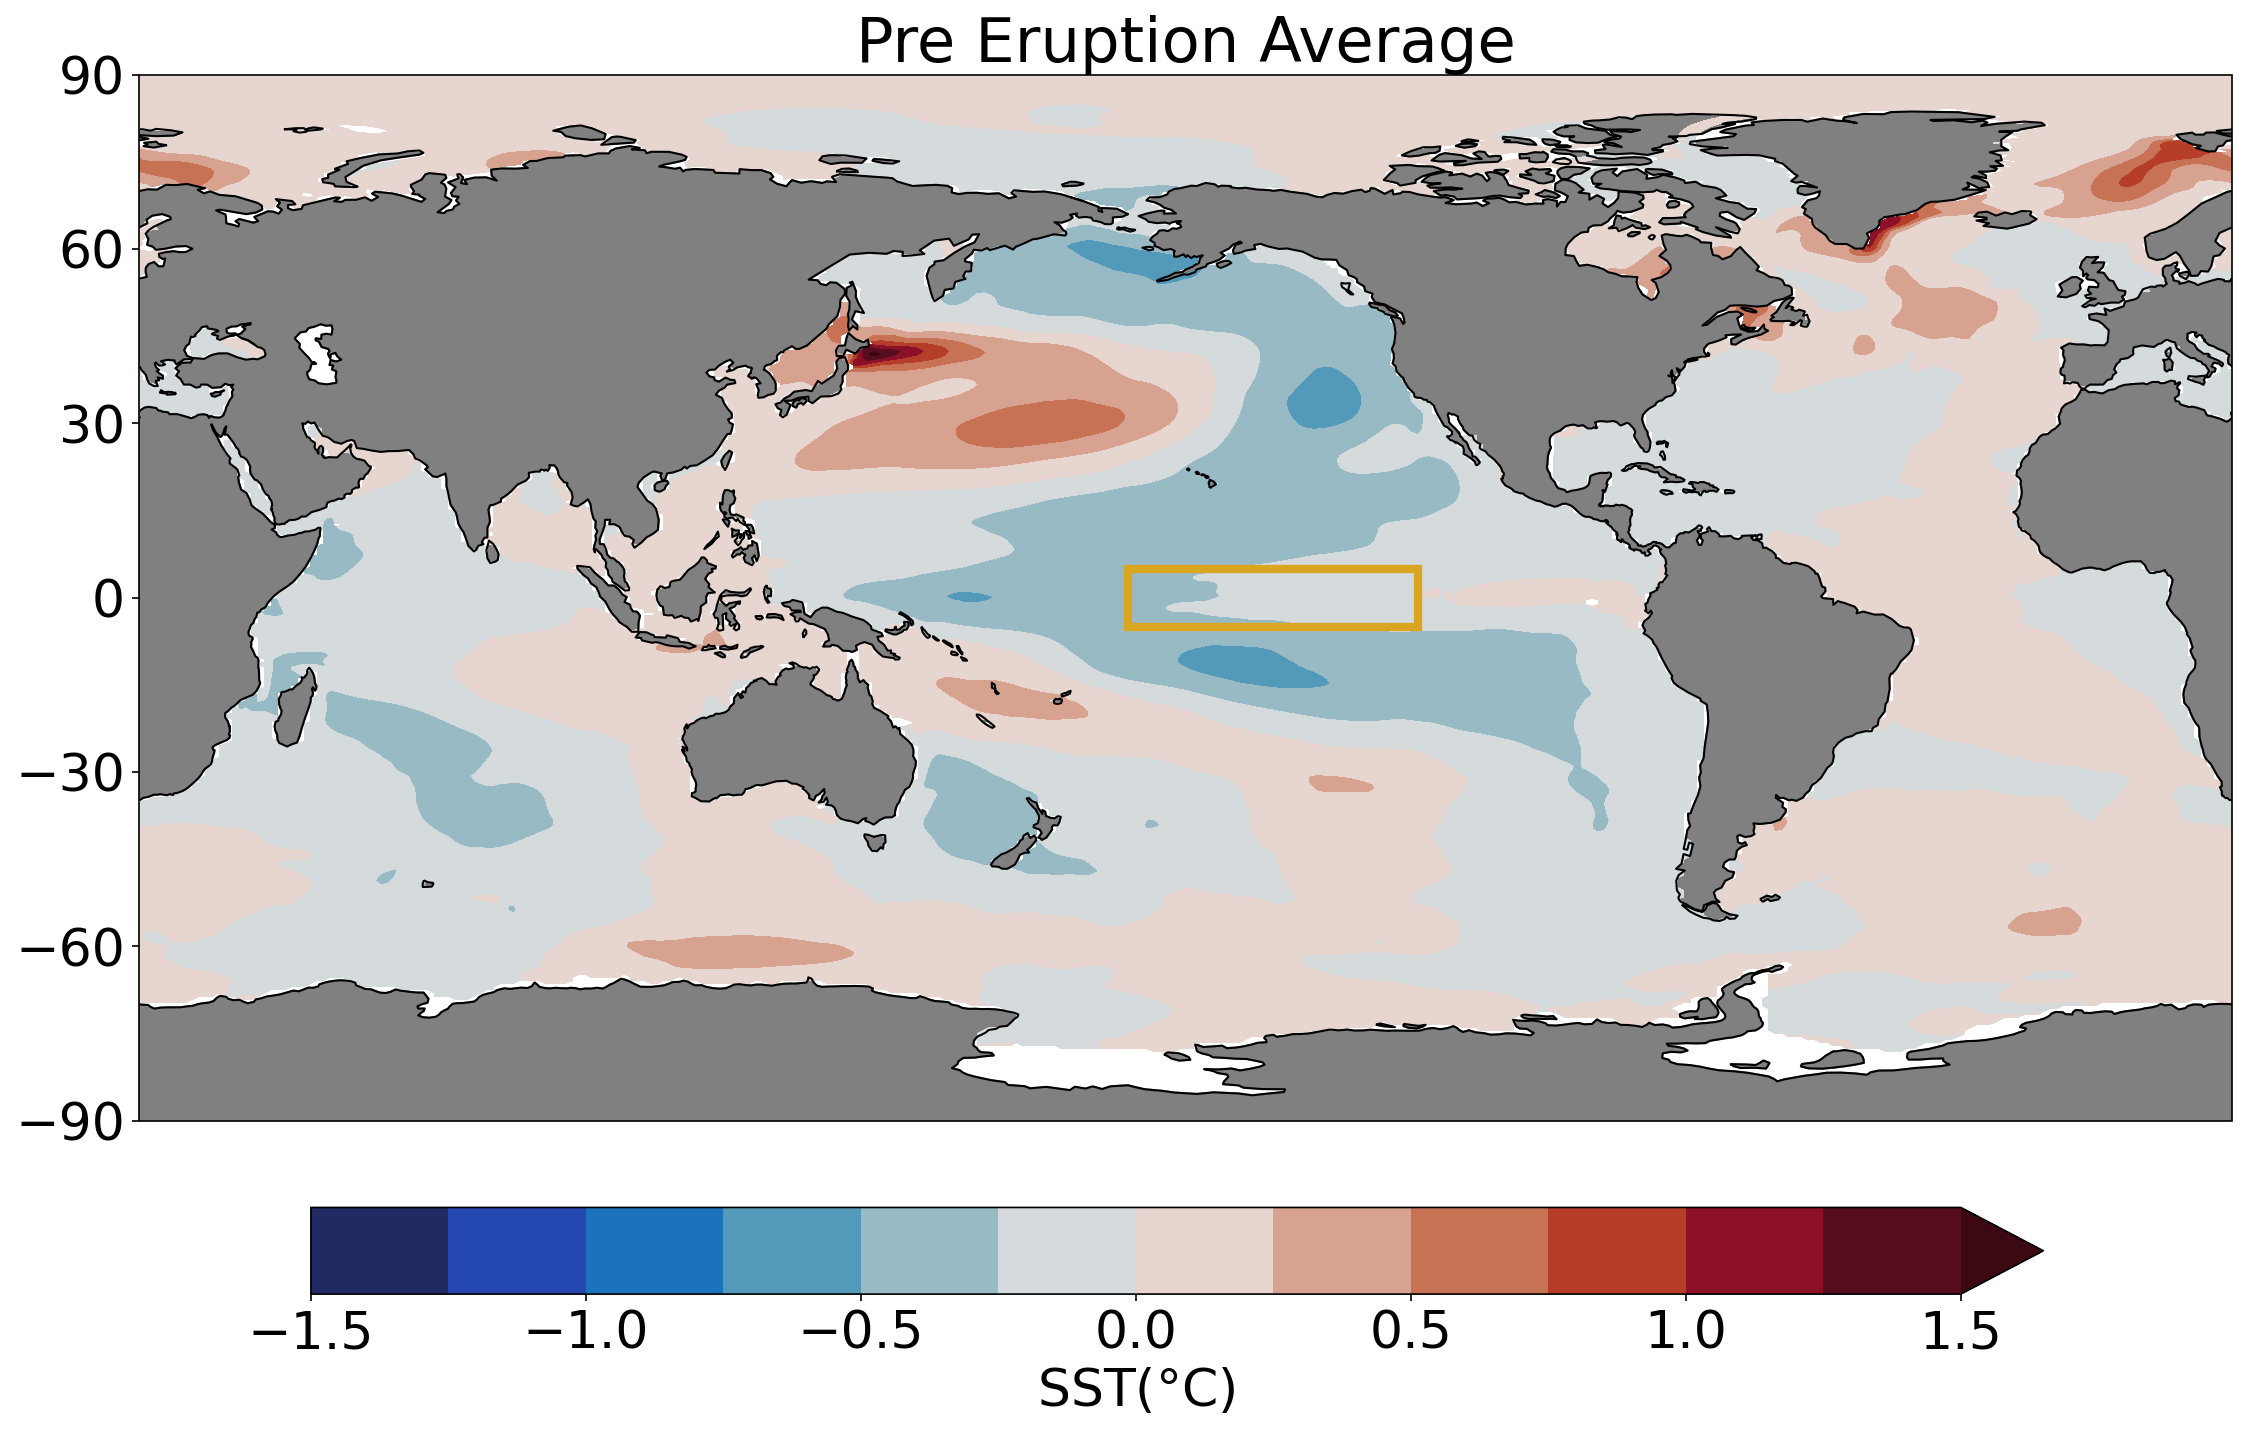

In [27]:
projection=ccrs.PlateCarree(central_longitude = -160)
#projection=ccrs.Robinson(central_longitude=-160, globe=None)
fig,ax= plt.subplots(figsize =(18,15),subplot_kw=dict(projection=projection))

ax.add_feature(cfeature.LAND, color = 'gray')
ax.add_feature(cfeature.COASTLINE)
ax.set_global()

min_level=-1.5
max_level=1.5
step_level=0.25

levels = np.arange(min_level, max_level + step_level, step_level)
p = plt.contourf(new_lons,new_lats, plot_data_pre_average,extend='max',levels=levels,
                transform=ccrs.PlateCarree(),cmap = cmocean.cm.balance,zorder=-1)
plt.yticks([-90, -60, -30, 0, 30, 60, 90], size=25)
#plt.axhline(y=5)
#plt.axhline(y=-5)
#plt.axvline(x=-10)
#plt.axvline(x=40)
        
ax.add_patch(mpatches.Rectangle((-10, 5), 50, -10, edgecolor='goldenrod',
   facecolor='none', linewidth=4))

plt.title('Pre Eruption Average', size=30)
cbar = plt.colorbar(p, orientation='horizontal', pad=0.05, fraction=0.05,ax=ax)
cbar.ax.tick_params(labelsize=25)
cbar.set_label('SST' + "($\degree$C)", size = 25)

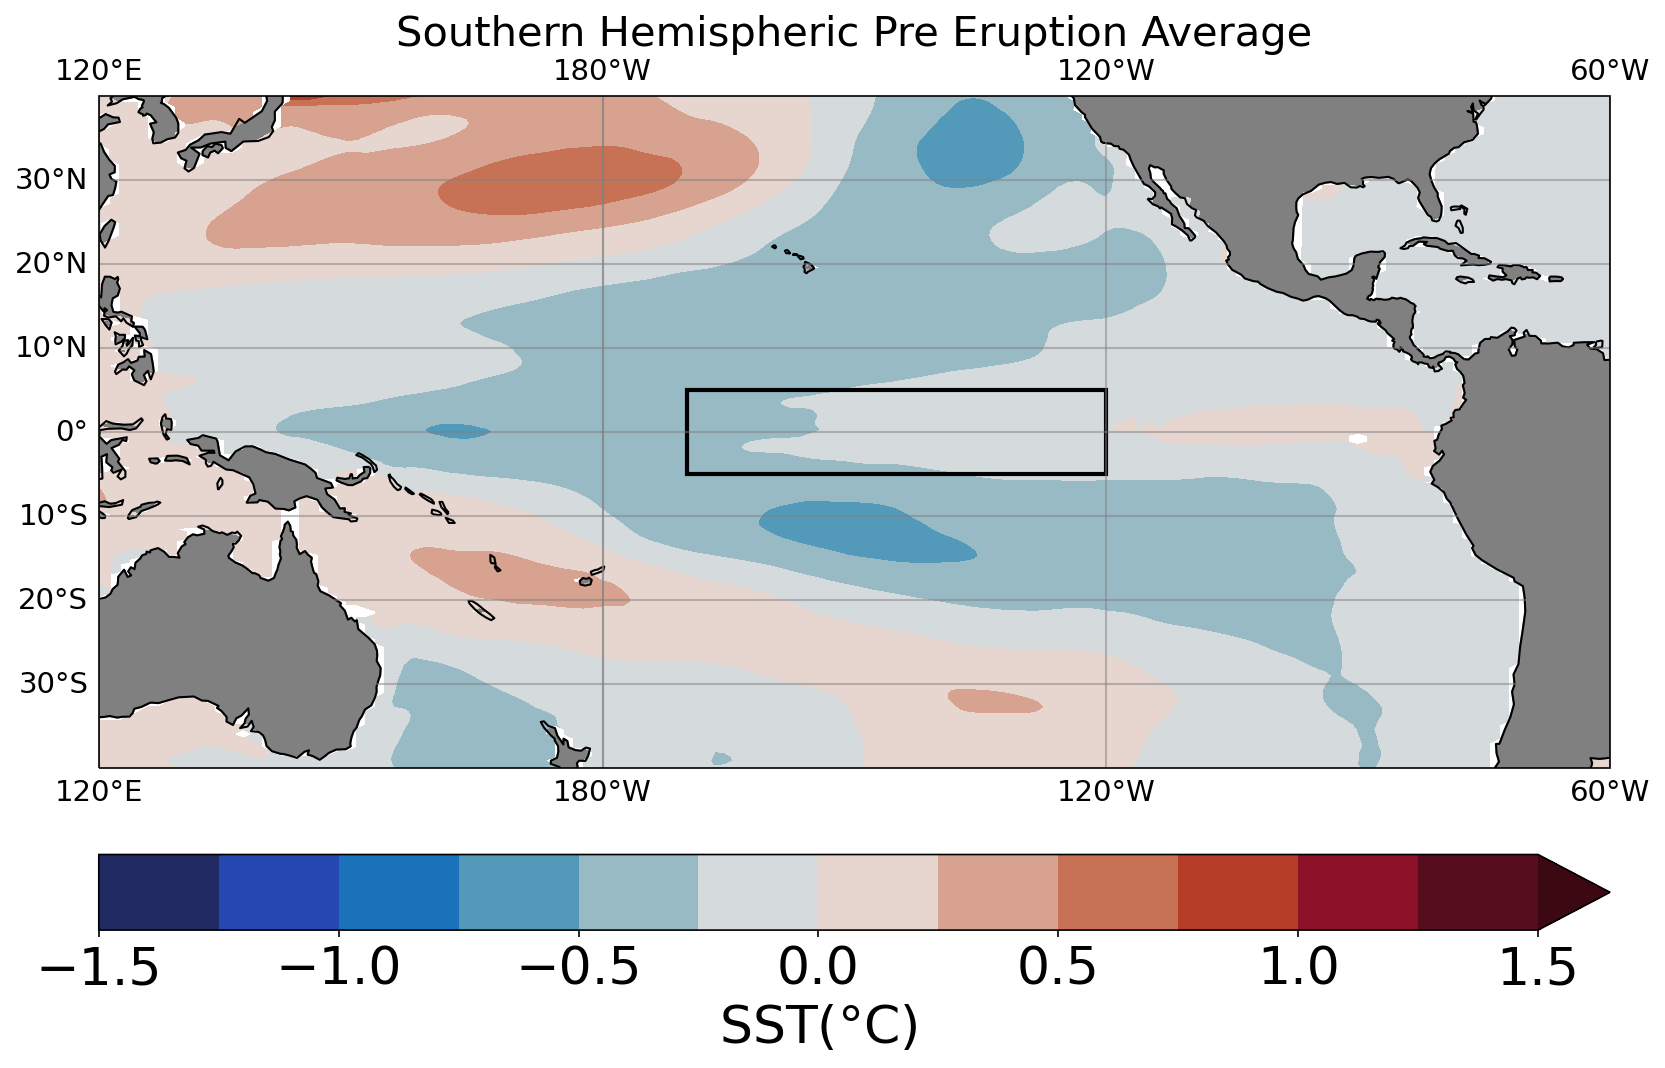

In [28]:
fig,ax= plt.subplots(figsize =(13,15),subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=-160)))
ax.add_feature(cfeature.LAND, color = 'grey',zorder=1)
ax.add_feature(cfeature.COASTLINE)
ax.set_global()

ax.set_extent([-240,-60,40,-40],crs=ccrs.PlateCarree() ) 

min_level=-1.5
max_level=1.5
step_level=0.25

p = plt.contourf(new_lons,new_lats, plot_data_pre_average,extend='max',levels=levels,
                transform=ccrs.PlateCarree(),cmap = cmocean.cm.balance)

gl1 = ax.gridlines(ccrs.PlateCarree(),
             linestyle='-',
             y_inline=False, x_inline=False,
             color='grey', alpha=.5, linewidth=1, draw_labels=True)
gl1.xformatter = LONGITUDE_FORMATTER
gl1.yformatter = LATITUDE_FORMATTER


ax.add_patch(mpatches.Rectangle((-10, 5), 50, -10, edgecolor='black',
   facecolor='none', linewidth=2))

plt.title('Southern Hemispheric Pre Eruption Average', size=20)
cbar = plt.colorbar(p, orientation='horizontal', pad=0.05, fraction=0.05,ax=ax)
cbar.ax.tick_params(labelsize=25)
cbar.set_label('SST' + "($\degree$C)", size = 25)

plt.show() 